# Elo Merchant Category Recommendation - Feature engineering
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import time
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from datetime import date
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)
gc.enable()

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

## Input data preparation
### Transactions
#### Load

In [4]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 267.72 MB
Reduced memory usage: 67.21 MB (74.9% reduction)
Starting memory usage: 300.52 MB
Reduced memory usage: 92.52 MB (69.2% reduction)


In [5]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

#### Preparation

In [ ]:
%%time
df_hist_trans = pd.read_csv("input/historical_transactions.csv") #, index_col='card_id'
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

In [ ]:
%%time
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv") # , index_col='card_id'
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

In [ ]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})
df_hist_trans['category_2'] = pd.to_numeric(df_hist_trans['category_2'])
df_hist_trans['category_3'] = df_hist_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [ ]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})
df_new_trans['category_2'] = pd.to_numeric(df_new_trans['category_2'])
df_new_trans['category_3'] = df_new_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [ ]:
def get_time_of_month(day_of_month):
    if day_of_month < 10:
        time_of_month = 0 # Beginning
    elif day_of_month >= 10 and day_of_month < 20:
        time_of_month = 1 # Middle
    else:
        time_of_month = 2 # End
    return time_of_month

In [ ]:
df_hist_trans['purchase_part_of_month'] = df_hist_trans['purchase_day'].apply(lambda x: get_time_of_month(x))

In [ ]:
df_new_trans['purchase_part_of_month'] = df_new_trans['purchase_day'].apply(lambda x: get_time_of_month(x))

In [ ]:
df_new_trans[:3]

In [ ]:
df_hist_trans[:3]

If you want to save transactions connecting specific customer vertices, use the block below.

In [ ]:
%%time
df_hist_trans.to_csv('preprocessed/trans_hist.csv')
df_new_trans.to_csv('preprocessed/trans_new.csv')

##### Calculating the number of transactions

In [ ]:
df_hist_gb_card_id = df_hist_trans.groupby("card_id").size().reset_index().set_index('card_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [ ]:
df_hist_gb_card_id[:3]

In [ ]:
df_hist_gb_merchant_id = df_hist_trans.groupby("merchant_id").size().reset_index().set_index('merchant_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [ ]:
df_hist_gb_merchant_id[:3]

##### Aggregation

In [ ]:
df_hist_trans = pd.merge(df_hist_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])

In [ ]:
df_new_trans = pd.merge(df_new_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])

In [ ]:
def aggregate_transactions(df, prefix):  
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],
        'active_months_lag3': ['sum', 'mean'],
        'active_months_lag6': ['sum', 'mean'],
        'active_months_lag12': ['sum', 'mean'],
        
        'avg_sales_lag3': ['sum', 'mean'],
        'avg_sales_lag6': ['sum', 'mean'], 
        'avg_sales_lag12': ['sum', 'mean'],
        
        'avg_purchases_lag3': ['sum', 'mean'], 
        'avg_purchases_lag6': ['sum', 'mean'], 
        'avg_purchases_lag12': ['sum', 'mean'], 

        'category_1_trans': ['sum', 'mean'],
        'category_1_merch': ['sum', 'mean'],
        'category_2_trans': ['sum', 'mean'],
        'category_2_merch': ['sum', 'mean'],
        'category_3': ['sum', 'mean'],
        'category_4': ['sum', 'mean'], 
        
        'city_id_trans': ['nunique'],
        'city_id_merch': ['nunique'],
        
        'installments': ['sum', 'median', 'mean', 'max', 'min', 'std'],

        'merchant_id': ['nunique'],
        'merchant_category_id_trans': ['nunique'],
        'merchant_category_id_merch': ['nunique'],
        'merchant_group_id': ['nunique'],
        'month_lag': ['min', 'max', 'mean'],
        
        'most_recent_sales_range': ['sum', 'mean', 'max', 'min', 'std'],
        'most_recent_purchases_range': ['sum', 'mean', 'max', 'min', 'std'],
        
        'numerical_1': ['mean', 'median', 'max', 'min', 'std'],
        'numerical_2': ['mean', 'median', 'max', 'min', 'std'],
        'number_of_transactions': ['mean', 'median', 'max', 'min', 'std'],

        'state_id_trans': ['nunique'],
        'state_id_merch': ['nunique'],
        'subsector_id_trans': ['nunique'],
        'subsector_id_merch': ['nunique'],
        
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_year': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_day': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_hour': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_weekofyear': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_dayofweek': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_quarter': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_part_of_month': ['mean', 'median']
    }
    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)

    df = (df_agg.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')

    return df_agg

In [ ]:
%%time
df_new_trans = aggregate_transactions(df_new_trans, prefix='new_')

In [ ]:
df_new_trans.to_csv('preprocessed/trans_merch_new_agg.csv')

In [ ]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

In [ ]:
%%time
df_hist_trans = aggregate_transactions(df_hist_trans, prefix='hist_')

In [ ]:
df_hist_trans.to_csv('preprocessed/trans_merch_hist_agg.csv')

### Train and test data
#### Load

In [6]:
df_train = pd.read_csv("preprocessed/train_parsed.csv", index_col="card_id")
df_test = pd.read_csv("preprocessed/test_parsed.csv", index_col="card_id")

#### Preparation

In [ ]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"], index_col="card_id")
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

In [ ]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"], index_col="card_id")
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

In [ ]:
df_train['elapsed_days'] = (np.datetime64('2018-02-01') - df_train['first_active_month'].values.astype('datetime64[D]')).astype(np.int64)
df_test['elapsed_days'] = (np.datetime64('2018-02-01') - df_test['first_active_month'].values.astype('datetime64[D]')).astype(np.int64)

In [ ]:
df_train[:3]

In [ ]:
df_test[:3]

In [ ]:
df_train["year"] = df_train["first_active_month"].dt.year
df_train["month"] = df_train["first_active_month"].dt.month

In [ ]:
df_test["year"] = df_test["first_active_month"].dt.year
df_test["month"] = df_test["first_active_month"].dt.month

In [ ]:
df_train = pd.merge(df_train, df_hist_gb_card_id, left_index=True, right_index=True, how='left')
df_test = pd.merge(df_test, df_hist_gb_card_id, left_index=True, right_index=True, how='left')

In [ ]:
df_train.to_csv('preprocessed/train_parsed.csv')
df_test.to_csv('preprocessed/test_parsed.csv')

### Merchants
#### Load

In [ ]:
df_merch = pd.read_csv("preprocessed/merchants_parsed.csv", index_col="merchant_id")

#### Preparation

In [ ]:
df_merch = pd.read_csv("input/merchants.csv", index_col="merchant_id")

In [ ]:
df_merch = df_merch.groupby(df_merch.index).first()

In [ ]:
df_merch[:3]

In [ ]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [ ]:
df_merch = pd.merge(df_merch, df_hist_gb_merchant_id, left_index=True, right_index=True, how='left')

In [ ]:
df_merch.to_csv('preprocessed/merchants_parsed.csv')

### Merging

In [7]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [8]:
df_train[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,target,year,month,number_of_transactions,hist_transactions_count,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median
0,C_ID_92a2005557,2017-06-01,5,2,1,-0.8203,2017,6,260,1,...,6.0,0.0,2.029297,1.478516,1.0,2.0,1.0,0.510742,1.0,1.0
1,C_ID_3d0044924f,2017-01-01,4,1,0,0.3928,2017,1,350,1,...,4.0,0.0,1.643555,1.000000,1.0,1.0,1.0,0.000000,1.0,1.0
2,C_ID_d639edf6cd,2016-08-01,2,2,0,0.6880,2016,8,43,1,...,5.0,5.0,NaN,2.000000,2.0,2.0,2.0,NaN,2.0,2.0


In [9]:
df_test[:3]

,card_id,first_active_month,feature_1,feature_2,feature_3,year,month,number_of_transactions,hist_transactions_count,hist_authorized_flag_sum,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_part_of_month_mean,new_purchase_part_of_month_median
0,C_ID_0ab67a22ab,2017-04-01,3,3,1,2017.0,4.0,68,1,44.0,...,5.0,2.0,1.527344,1.000000,1.0,1.0,1.0,0.000000,1.000000,1.0
1,C_ID_130fd0cbdd,2017-01-01,2,3,0,2017.0,1.0,78,1,77.0,...,6.0,0.0,2.291016,1.444336,1.0,2.0,1.0,0.526855,0.777832,1.0
2,C_ID_b709037bc5,2017-08-01,5,1,1,2017.0,8.0,13,1,9.0,...,3.0,1.0,1.414062,1.000000,1.0,1.0,1.0,0.000000,0.500000,0.5


## Feature selection

In [10]:
cols = ['feature_1', 'feature_2', 'feature_3', 'year', 'month', 'number_of_transactions', 'hist_transactions_count', 'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_active_months_lag3_sum', 'hist_active_months_lag3_mean', 'hist_active_months_lag6_sum', 'hist_active_months_lag6_mean', 'hist_active_months_lag12_sum', 'hist_active_months_lag12_mean', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_avg_purchases_lag3_sum', 'hist_avg_purchases_lag3_mean', 'hist_avg_purchases_lag6_sum', 'hist_avg_purchases_lag6_mean', 'hist_avg_purchases_lag12_sum', 'hist_avg_purchases_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_trans_mean', 'hist_category_1_merch_sum', 'hist_category_1_merch_mean', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_3_sum', 'hist_category_3_mean', 'hist_category_4_sum', 'hist_category_4_mean', 'hist_city_id_trans_nunique', 'hist_city_id_merch_nunique', 'hist_installments_sum', 'hist_installments_median', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_merchant_id_nunique', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_group_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_mean', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_min', 'hist_most_recent_sales_range_std', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_mean', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_min', 'hist_most_recent_purchases_range_std', 'hist_numerical_1_mean', 'hist_numerical_1_median', 'hist_numerical_1_max', 'hist_numerical_1_min', 'hist_numerical_1_std', 'hist_numerical_2_mean', 'hist_numerical_2_median', 'hist_numerical_2_max', 'hist_numerical_2_min', 'hist_numerical_2_std', 'hist_number_of_transactions_mean', 'hist_number_of_transactions_median', 'hist_number_of_transactions_max', 'hist_number_of_transactions_min', 'hist_number_of_transactions_std', 'hist_state_id_trans_nunique', 'hist_state_id_merch_nunique', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_merch_nunique', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_min', 'hist_purchase_year_std', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_dayofweek_mean', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_std', 'hist_purchase_quarter_mean', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_std', 'hist_purchase_part_of_month_mean', 'hist_purchase_part_of_month_median', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag6_mean', 'new_active_months_lag12_sum', 'new_active_months_lag12_mean', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_trans_mean', 'new_category_1_merch_sum', 'new_category_1_merch_mean', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_merch_sum', 'new_category_2_merch_mean', 'new_category_3_sum', 'new_category_3_mean', 'new_category_4_sum', 'new_category_4_mean', 'new_city_id_trans_nunique', 'new_city_id_merch_nunique', 'new_installments_sum', 'new_installments_median', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_merchant_id_nunique', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_merch_nunique', 'new_merchant_group_id_nunique', 'new_month_lag_min', 'new_month_lag_max', 'new_month_lag_mean', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_mean', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_min', 'new_most_recent_sales_range_std', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_mean', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_std', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_min', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_min', 'new_numerical_2_std', 'new_number_of_transactions_mean', 'new_number_of_transactions_median', 'new_number_of_transactions_max', 'new_number_of_transactions_min', 'new_number_of_transactions_std', 'new_state_id_trans_nunique', 'new_state_id_merch_nunique', 'new_subsector_id_trans_nunique', 'new_subsector_id_merch_nunique', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_std', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_std', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_std', 'new_purchase_part_of_month_mean', 'new_purchase_part_of_month_median']
X = df_train[cols].copy()
y = df_train.target

In [12]:
X.columns.tolist()

['feature_1',
 'feature_2',
 'feature_3',
 'year',
 'month',
 'number_of_transactions',
 'hist_transactions_count',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_active_months_lag3_sum',
 'hist_active_months_lag3_mean',
 'hist_active_months_lag6_sum',
 'hist_active_months_lag6_mean',
 'hist_active_months_lag12_sum',
 'hist_active_months_lag12_mean',
 'hist_avg_sales_lag3_sum',
 'hist_avg_sales_lag3_mean',
 'hist_avg_sales_lag6_sum',
 'hist_avg_sales_lag6_mean',
 'hist_avg_sales_lag12_sum',
 'hist_avg_sales_lag12_mean',
 'hist_avg_purchases_lag3_sum',
 'hist_avg_purchases_lag3_mean',
 'hist_avg_purchases_lag6_sum',
 'hist_avg_purchases_lag6_mean',
 'hist_avg_purchases_lag12_sum',
 'hist_avg_purchases_lag12_mean',
 'hist_category_1_trans_sum',
 'hist_category_1_trans_mean',
 'hist_category_1_merch_sum',
 'hist_category_1_merch_mean',
 'hist_category_2_trans_sum',
 'hist_category_2_trans_mean',
 'hist_category_2_merch_sum',
 'hist_category_2_merch_mean',
 'hist_categor

### 6 Ways for Feature Selection
https://www.kaggle.com/sz8416/6-ways-for-feature-selection

#### Pearson correlation

In [26]:
def cor_selector(X, y, limit=500):
    cor_list = []
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-limit:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in X.columns.tolist()]
    return cor_support, cor_feature, cor_list

In [27]:
cor_support, cor_feature, cor_value = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

244 selected features


In [15]:
cor_support

[True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fal

In [16]:
cor_feature

['hist_month_lag_min',
 'hist_purchase_day_mean',
 'hist_city_id_merch_nunique',
 'hist_purchase_day_std',
 'hist_purchase_day_median',
 'hist_numerical_2_median',
 'hist_number_of_transactions_std',
 'hist_numerical_1_median',
 'hist_state_id_merch_nunique',
 'hist_number_of_transactions_median',
 'hist_numerical_2_std',
 'hist_numerical_1_std',
 'hist_installments_std',
 'hist_month_lag_mean',
 'hist_active_months_lag12_mean',
 'hist_purchase_part_of_month_median',
 'hist_purchase_dayofweek_median',
 'hist_purchase_amount_min',
 'hist_most_recent_purchases_range_std',
 'hist_installments_max',
 'feature_2',
 'hist_city_id_trans_nunique',
 'hist_purchase_dayofweek_mean',
 'hist_number_of_transactions_mean',
 'hist_most_recent_sales_range_std',
 'hist_authorized_flag_sum',
 'hist_purchase_hour_std',
 'hist_active_months_lag6_mean',
 'hist_avg_sales_lag12_sum',
 'hist_merchant_group_id_nunique',
 'feature_3',
 'hist_avg_sales_lag6_sum',
 'hist_merchant_id_nunique',
 'hist_avg_sales_lag3

In [31]:
df_c_supp = pd.DataFrame(data={
    'variable_name': cor_feature,
    'corr_coeff': cor_value
})

df_c_supp.sort_values('corr_coeff', axis=0, inplace=True, ascending=False)

In [41]:
df_c_supp[:5]

,variable_name,corr_coeff
90,new_most_recent_sales_range_mean,0.132301
92,new_merchant_id_nunique,0.120957
97,new_purchase_weekofyear_median,0.072151
112,hist_avg_purchases_lag6_mean,0.071287
122,new_purchase_weekofyear_max,0.062548


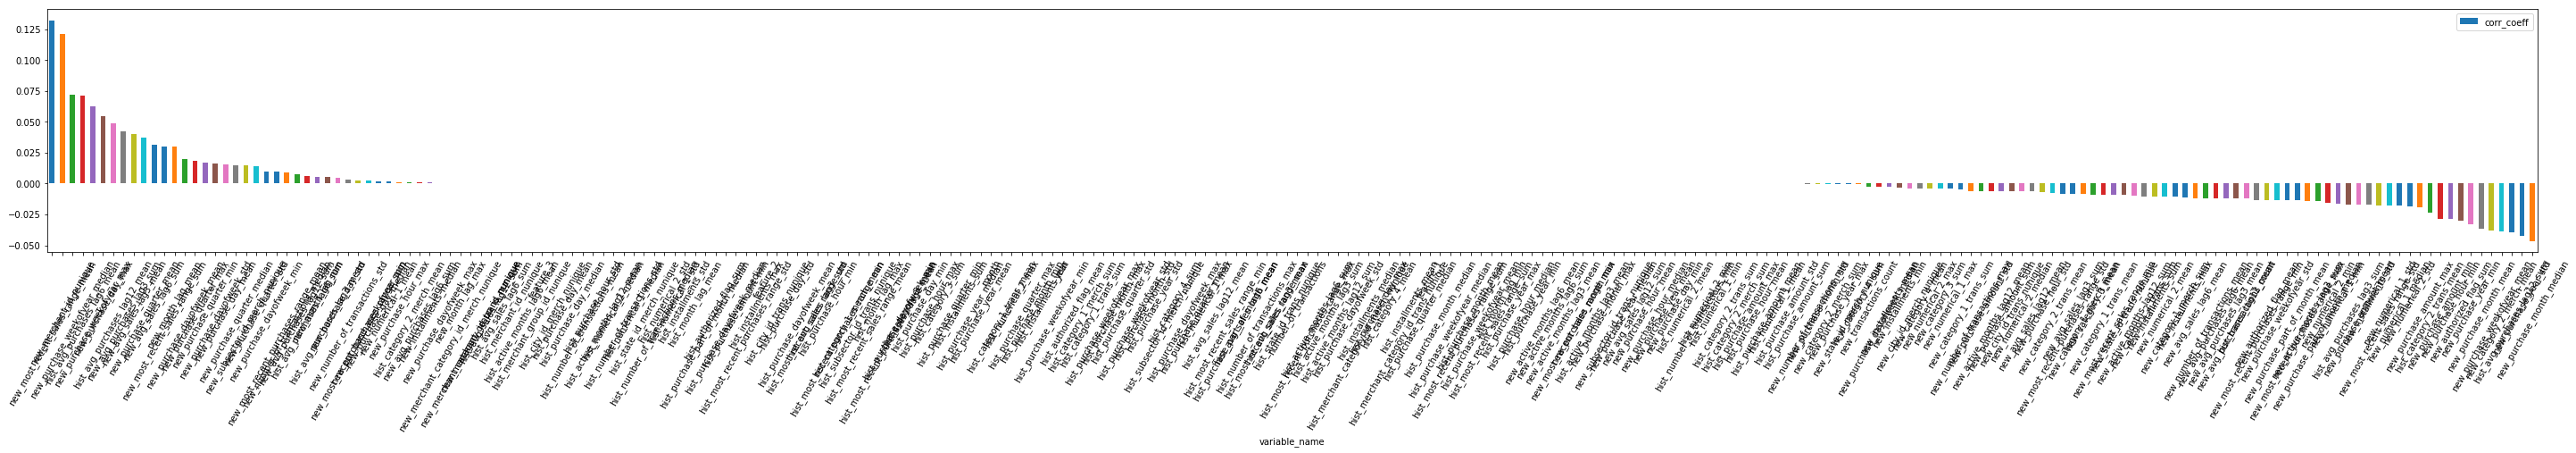

In [38]:
df_c_supp.plot.bar(x='variable_name', y='corr_coeff', rot=60, figsize=(50, 5))

In [43]:
cols_2_use = df_c_supp[df_c_supp['corr_coeff'] > 0]['variable_name']
len(df_c_supp[df_c_supp['corr_coeff'] > 0])

43

In [45]:
list(cols_2_use)

['new_most_recent_sales_range_mean',
 'new_merchant_id_nunique',
 'new_purchase_weekofyear_median',
 'hist_avg_purchases_lag6_mean',
 'new_purchase_weekofyear_max',
 'new_purchase_day_max',
 'hist_avg_purchases_lag12_mean',
 'new_avg_purchases_lag3_sum',
 'new_avg_sales_lag3_mean',
 'new_purchase_quarter_mean',
 'new_avg_sales_lag6_sum',
 'new_most_recent_sales_range_sum',
 'new_month_lag_mean',
 'new_purchase_dayofweek_mean',
 'new_purchase_quarter_max',
 'new_purchase_quarter_min',
 'new_purchase_dayofweek_std',
 'new_purchase_day_mean',
 'new_purchase_quarter_median',
 'new_subsector_id_merch_nunique',
 'new_purchase_quarter_std',
 'new_purchase_dayofweek_min',
 'new_most_recent_purchases_range_mean',
 'new_number_of_transactions_median',
 'new_avg_purchases_lag12_sum',
 'hist_avg_purchases_lag6_sum',
 'new_month_lag_min',
 'hist_avg_purchases_lag3_mean',
 'new_purchase_day_std',
 'new_number_of_transactions_std',
 'new_most_recent_purchases_range_sum',
 'new_purchase_weekofyear_min

#### Chi-2

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=5)
chi_selector.fit(X_norm, y)

#### RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=5, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

In [ ]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

#### Embedded

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X_norm, y)

In [ ]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

#### Random Forest

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=5), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

#### LightGBM

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

In [ ]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

### Feature importance and dependence plot with shap
https://www.kaggle.com/sz8416/6-ways-for-feature-selection

[Feature Selection with Null Importances](https://www.kaggle.com/ogrellier/feature-selection-with-null-importances)

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [ ]:
def get_feature_importances(data, shuffle, seed=None):
    train_features = [f for f in data if f not in ['card_id', 'target']]
    y = data['target'].copy()
    if shuffle:
        y = data['target'].copy().sample(frac=1.0)

    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'bagging_freq': 1,
        'boosting_type': 'gbdt', # rf
        'colsample_bytree': 0.7,
        'max_depth': 8,
        'num_leaves': 127,
        'n_jobs': 4,
        'objective': 'binary',
        'seed': seed,
        'subsample': 0.623
    }
    
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)
    #, categorical_feature=categorical_feats

    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [ ]:
np.random.seed(123)

actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [ ]:
actual_imp_df[:3]

In [ ]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

In [ ]:
null_imp_df[:3]

In [ ]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

In [ ]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='LIVINGAPARTMENTS_AVG')

In [ ]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

In [ ]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [ ]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75034

https://www.kaggle.com/roydatascience/recursive-feature-selection-using-sklearn-on-elo?scriptVersionId=9969948